Coefficients: [0.5 0.5]
Intercept: 0.5000000000000009
Predictions: [6. 7.]


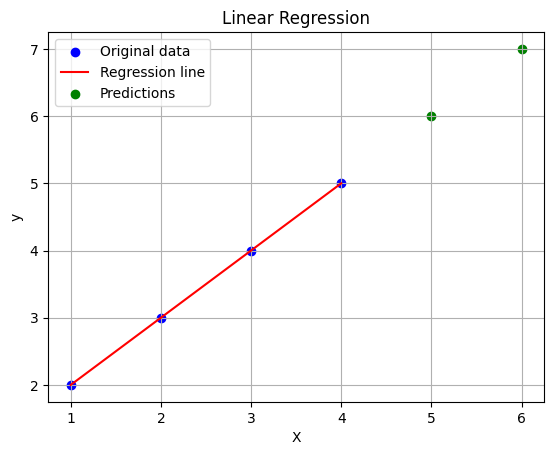

In [24]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from matplotlib.animation import FuncAnimation
import pandas as pd
import time

# Sample data (replace with your own dataset)
X = np.array([[1, 2], [2, 3], [3, 4], [4, 5]])  # Independent variables
y = np.array([2, 3, 4, 5])                      # Dependent variable

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Print the coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Predict using the trained model
new_data = np.array([[5, 6], [6, 7]])  # New data for prediction
predictions = model.predict(new_data)
print("Predictions:", predictions)

# Plotting
plt.scatter(X[:,0], y, color='blue', label='Original data')  # Plot original data
plt.plot(X[:,0], model.predict(X), color='red', label='Regression line')  # Plot regression line
plt.scatter(new_data[:,0], predictions, color='green', label='Predictions')  # Plot predicted points
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
from openfhe import *

In [32]:
# parameters = CCParamsBFVRNS()
# parameters.SetPlaintextModulus(65537)
# parameters.SetMultiplicativeDepth(2)

# crypto_context = GenCryptoContext(parameters)
# # Enable features that you wish to use
# crypto_context.Enable(PKESchemeFeature.PKE)
# crypto_context.Enable(PKESchemeFeature.key_pairWITCH)
# crypto_context.Enable(PKESchemeFeature.LEVELEDSHE)

# # Sample Program: Step 2: Key Generation

# # Generate a public/private key pair
# key_pair = crypto_context.KeyGen()

# # Generate the relinearization key
# crypto_context.EvalMultKeyGen(key_pair.secretKey)

# # Generate the rotation evaluation key_pair
# crypto_context.EvalRotateKeyGen(key_pair.secretKey, [1, 2, -1, -2])
url = 'https://media.geeksforgeeks.org/wp-content/uploads/20240320114716/data_for_lr.csv'
data = pd.read_csv(url)
data
# Drop the missing values
data = data.dropna()
# training dataset and labels
X = np.array(data.x[0:50]).reshape(50, 1)
Y = np.array(data.y[0:50]).reshape(50, 1)

num_iterations = 1
mult_depth = 1
scale_mod_size = 50
# batch_size = 8
parameters = CCParamsCKKSRNS()
secret_key_dist = SecretKeyDist.UNIFORM_TERNARY
parameters.SetSecretKeyDist(secret_key_dist)
parameters.SetSecurityLevel(SecurityLevel.HEStd_NotSet)
parameters.SetRingDim(1 << 12)

if get_native_int()==128:
    rescale_tech = ScalingTechnique.FIXEDAUTO
    dcrt_bits = 78
    first_mod = 89
else:
    rescale_tech = ScalingTechnique.FLEXIBLEAUTO
    dcrt_bits = 59
    first_mod = 60

parameters.SetScalingModSize(dcrt_bits)
parameters.SetScalingTechnique(rescale_tech)
parameters.SetFirstModSize(first_mod)


level_budget = [1, 1]
bsgs_dim = [1,1]

levels_available_after_bootstrap = 10
depth = levels_available_after_bootstrap + FHECKKSRNS.GetBootstrapDepth(level_budget, secret_key_dist) + (num_iterations - 1)
parameters.SetMultiplicativeDepth(depth)

crypto_context = GenCryptoContext(parameters)
crypto_context.Enable(PKESchemeFeature.PKE)
crypto_context.Enable(PKESchemeFeature.KEYSWITCH)
crypto_context.Enable(PKESchemeFeature.LEVELEDSHE)
crypto_context.Enable(PKESchemeFeature.ADVANCEDSHE)
crypto_context.Enable(PKESchemeFeature.FHE)
ring_dim = crypto_context.GetRingDimension()
print(f"CKKS is using ring dimension {ring_dim}\n\n")

num_slots = 1
crypto_context.EvalBootstrapSetup(level_budget, bsgs_dim, num_slots)

print("The CKKS scheme is using ring dimension: " + str(crypto_context.GetRingDimension()))
key_pair = crypto_context.KeyGen()
crypto_context.EvalMultKeyGen(key_pair.secretKey)
crypto_context.EvalBootstrapKeyGen(key_pair.secretKey, num_slots)

# crypto_context.EvalRotateKeyGen(key_pair.secretKey, [1, -2])


CKKS is using ring dimension 4096


The CKKS scheme is using ring dimension: 4096


In [33]:
E_X = []
for x in X:
    plaintext1 = crypto_context.MakeCKKSPackedPlaintext([x])
    E_X.append(crypto_context.Encrypt(key_pair.publicKey, plaintext1))
E_Y = []
for y in Y:
    plaintext1 = crypto_context.MakeCKKSPackedPlaintext([y])
    E_Y.append(crypto_context.Encrypt(key_pair.publicKey, plaintext1))
print(f'E_X: {E_X}')
print(f'E_X: {E_Y}')


E_X: [<openfhe.Ciphertext object at 0x16a732bb0>, <openfhe.Ciphertext object at 0x292d85270>, <openfhe.Ciphertext object at 0x171f69bf0>, <openfhe.Ciphertext object at 0x171f69a30>, <openfhe.Ciphertext object at 0x171f691f0>, <openfhe.Ciphertext object at 0x171f69330>, <openfhe.Ciphertext object at 0x171f69870>, <openfhe.Ciphertext object at 0x171f694f0>, <openfhe.Ciphertext object at 0x171f692f0>, <openfhe.Ciphertext object at 0x171f697f0>, <openfhe.Ciphertext object at 0x171f69cb0>, <openfhe.Ciphertext object at 0x171f69bb0>, <openfhe.Ciphertext object at 0x171f69930>, <openfhe.Ciphertext object at 0x171f698b0>, <openfhe.Ciphertext object at 0x171f695b0>, <openfhe.Ciphertext object at 0x171f69a70>, <openfhe.Ciphertext object at 0x171f69530>, <openfhe.Ciphertext object at 0x171f69770>, <openfhe.Ciphertext object at 0x171f698f0>, <openfhe.Ciphertext object at 0x171f69eb0>, <openfhe.Ciphertext object at 0x171f69e30>, <openfhe.Ciphertext object at 0x171f69c30>, <openfhe.Ciphertext object

/var/folders/9w/8ng_07_j477g3xhs5f7vds_c0000gn/T/ipykernel_73121/1993741279.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plaintext1 = crypto_context.MakeCKKSPackedPlaintext([x])
/var/folders/9w/8ng_07_j477g3xhs5f7vds_c0000gn/T/ipykernel_73121/1993741279.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plaintext1 = crypto_context.MakeCKKSPackedPlaintext([y])


In [43]:
class HomomorphicLinearRegression:
    def __init__(self, crypto_context, key_pair):
        self.crypto_context = crypto_context
        self.key_pair = key_pair
        self.parameters = {}

    def encrypt_data(self, X, y):
        

        E_X = []
        for x in X:
            plaintext1 = crypto_context.MakeCKKSPackedPlaintext([x],1, depth -1,None,1)
            E_X.append(crypto_context.Encrypt(key_pair.publicKey, plaintext1))
        E_Y = []
        for y in Y:
            plaintext1 = crypto_context.MakeCKKSPackedPlaintext([y],1, depth -1,None,1)
            E_Y.append(crypto_context.Encrypt(key_pair.publicKey, plaintext1))
        return E_X, E_Y

    def forward_propagation(self, train_input):
        m = self.parameters['m']
        c= self.parameters['c']
        y_hats = []
        # level_budget = [1, 1]
        # bsgs_dim = [1,1]
        for x in range(len(train_input)):
            # self.crypto_context.EvalBootstrapSetup(level_budget, bsgs_dim, 1)
            # self.crypto_context.EvalBootstrapKeyGen(self.key_pair.secretKey, 1)
            ciphertext_after = self.crypto_context.EvalBootstrap(train_input[x])
            eval_mul = self.crypto_context.EvalMult(ciphertext_after,m)
            eval_sum = self.crypto_context.EvalAdd(eval_mul,c)
            
            y_hats.append(eval_sum)
        # for y_hat in y_hats:
        #     result = self.crypto_context.Decrypt(y_hat,self.key_pair.secretKey)
        #     result.SetLength(1)
        #     print("y_hat = " + str(result))


        return y_hats

    def cost_function(self, predictions, train_output):
        if len(predictions) != len(train_output):
            return
        eval_cost = 0
        for y_hat, output in zip(predictions, train_output):
            eval_sub = self.crypto_context.EvalSub(y_hat,output)
            ciphertext_after = self.crypto_context.EvalBootstrap(eval_sub)
            eval_square = self.crypto_context.EvalSquare(ciphertext_after)
            eval_cost = self.crypto_context.EvalAdd(eval_square,eval_cost)
        ciphertext_after = self.crypto_context.EvalBootstrap(eval_cost)
        eval_cost = self.crypto_context.EvalMult(eval_cost,1/len(predictions))
        # result = self.crypto_context.Decrypt(eval_cost,self.key_pair.secretKey)
        # result.SetLength(1)
        # print("eval_cost = " + str(result))
        return eval_cost

    def mean_homo(self, Z):

        eval_cost = 0
        for z in Z:
            eval_cost = self.crypto_context.EvalAdd(z,eval_cost)
        c = 1 / len(Z)
        # Adjust noiseScaleDeg and level as needed
        ciphertext_after = self.crypto_context.EvalBootstrap(eval_cost)
        eval_mean = self.crypto_context.EvalMult(ciphertext_after,c)
        return eval_mean

    def backward_propagation(self, train_input, train_output, predictions):
        derivates = {}
        two = 2  # Adjust noiseScaleDeg and level as needed
        # Calculate dm 
        dfs = []
        for pred, output in zip(predictions, train_output):
            df = self.crypto_context.EvalSub(pred,output)
            dfs.append(df)
        eval_muls = []
        for i, df in zip(train_input, dfs):
            ciphertext_after = self.crypto_context.EvalBootstrap(i)
            ciphertext_after2 = self.crypto_context.EvalBootstrap(df)
            eval_mul = self.crypto_context.EvalMult(ciphertext_after,ciphertext_after2)
            eval_muls.append(eval_mul)
        mean = self.mean_homo(eval_muls)
        ciphertext_after = self.crypto_context.EvalBootstrap(mean)
        dm = self.crypto_context.EvalMult(ciphertext_after,two)
        # Calcualte the dc
        mean = self.mean_homo(dfs)
        ciphertext_after = self.crypto_context.EvalBootstrap(mean)
        dc = self.crypto_context.EvalMult(ciphertext_after, two)

        # Assign values to dm and dc
        derivates["dm"] = self.crypto_context.EvalBootstrap(dm)
        derivates["dc"] = self.crypto_context.EvalBootstrap(dc)
        return derivates

    def update_parameters(self, derivates, learning_rate):
        self.parameters["m"] = self.crypto_context.EvalSub(
            self.parameters["m"],
            self.crypto_context.EvalMult(learning_rate, derivates["dm"]),
        )
        self.parameters["c"] = self.crypto_context.EvalSub(
            self.parameters["c"],
            self.crypto_context.EvalMult(learning_rate, derivates["dc"]),
        )

    ##########################

    def train(self, E_X, E_Y, num_iterations=100, learning_rate=0.0001):
        # Assuming E_X is structured correctly as per previous discussions
        # num_samples = len(E_X)  # Number of samples
        num_features = 8  # Assuming this is the correct way to determine the number of features

        # Initialize coefficients (weights and intercept) as encrypted 0.0 values
        # initial_plaintext = self.crypto_context.MakeCKKSPackedPlaintext([0.0])  # Adjust noiseScaleDeg and level as needed
        # self.coefficients = [self.crypto_context.Encrypt(self.key_pair.publicKey, initial_plaintext) for _ in range(num_features + 1)]
        
        self.parameters["m"] = np.random.uniform(0, 1) * -1
        
        self.parameters["c"] = np.random.uniform(0, 1) * -1
        self.loss = []

        # Initialize figure and axis for animation
        # fig, ax = plt.subplots()
        # x_vals = np.linspace(min(E_X), max(E_X), 100)
        # line, = ax.plot(x_vals, self.parameters['m'] * x_vals +
        #                 self.parameters['c'], color='red', label='Regression Line')
        # ax.scatter(X, y, marker='o',
        #         color='green', label='Training Data')

        # # Set y-axis limits to exclude negative values
        # ax.set_ylim(0, max(y) + 1)

        def update(i):
            # Forward propagation
            start_fp = time.time()
            predictions = self.forward_propagation(E_X)
            end_fp = time.time()
            print(f"Forward propagation took {(end_fp - start_fp)/60:.8f} minutes.")
            # print(f"predictions: {predictions}")
            # print(f'E_Y: {E_Y}')
            # # Cost function
            # # Cost function
            start_cf = time.time()
            cost = self.cost_function(predictions, E_Y)
            end_cf = time.time()
            print(f"Cost function calculation took {(end_cf - start_cf)/60:.8f} minutes.")

            # # Back propagation
            start_bp = time.time()
            derivatives = self.backward_propagation(E_X, E_Y, predictions)
            end_bp = time.time()
            print(f"Back propagation took {(end_bp - start_bp)/60:.8f} minutes.")

            # # Update parameters
            self.update_parameters(derivatives, learning_rate)

            # # Update the regression line
            # # line.set_ydata(self.parameters['m']
            # #             * x_vals + self.parameters['c'])

            # Append loss and print
            self.loss.append(cost)
            print("Iteration = {}, Loss = {}".format(i + 1, cost))

            # return line,

        for i in range(40):
            update(i)

        m = self.crypto_context.Decrypt(self.parameters['m'],self.key_pair.secretKey)
        c = self.crypto_context.Decrypt(self.parameters['c'],self.key_pair.secretKey)
        # # Create animation
        # ani = FuncAnimation(fig, update, frames=num_iterations, interval=200, blit=True)
        # # Save the animation as a video file (e.g., MP4)
        # ani.save('linear_regression_A.gif', writer='ffmpeg')

        # plt.xlabel('Input')
        # plt.ylabel('Output')
        # plt.title('Linear Regression')
        # plt.legend()
        # plt.show()

        return m,c

    def decrypt_coefficients(self):
        if self.coefficients is None:
            print("Model coefficients are not trained yet.")
            return None
        else:
            return [
                self.crypto_context.Decrypt(self.key_pair.secretKey, coeff)
                for coeff in self.coefficients
            ]


In [44]:
# Initialize the class with cryptographic context and key pair
homo_lr = HomomorphicLinearRegression(crypto_context, key_pair)


# Encrypt the data
start_encrypt = time.time()
E_X, E_Y = homo_lr.encrypt_data(X, y)
end_encrypt = time.time()
print(f"Data encryption took {(end_encrypt - start_encrypt) / 60 :.8f} minutes.")


# Train the model
start_train = time.time()
m,c =homo_lr.train(E_X, E_Y)
end_train = time.time()
print(f"Model training took {(end_train - start_train) / 60:.8f} minutes.")

# Decrypt the trained coefficients
# coefficients = homo_lr.decrypt_coefficients()
# print("Trained coefficients:", coefficients)

/var/folders/9w/8ng_07_j477g3xhs5f7vds_c0000gn/T/ipykernel_73121/926598752.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plaintext1 = crypto_context.MakeCKKSPackedPlaintext([x],1, depth -1,None,1)
/var/folders/9w/8ng_07_j477g3xhs5f7vds_c0000gn/T/ipykernel_73121/926598752.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plaintext1 = crypto_context.MakeCKKSPackedPlaintext([y],1, depth -1,None,1)


Data encryption took 0.00154072 minutes.
Forward propagation took 0.20392240 minutes.
Cost function calculation took 0.20770768 minutes.
Back propagation took 0.42951037 minutes.
Iteration = 1, Loss = <openfhe.Ciphertext object at 0x292ac77b0>
Forward propagation took 0.20418858 minutes.
Cost function calculation took 0.20708653 minutes.
Back propagation took 0.42852310 minutes.
Iteration = 2, Loss = <openfhe.Ciphertext object at 0x292f52830>
Forward propagation took 0.20391968 minutes.
Cost function calculation took 0.20957598 minutes.
Back propagation took 51.43620445 minutes.
Iteration = 3, Loss = <openfhe.Ciphertext object at 0x292a4b6f0>
Forward propagation took 32.20048207 minutes.
Cost function calculation took 33.17175720 minutes.
Back propagation took 60.00797433 minutes.
Iteration = 4, Loss = <openfhe.Ciphertext object at 0x171f678f0>
Forward propagation took 5.30358468 minutes.
Cost function calculation took 16.00820555 minutes.
Back propagation took 50.04338198 minutes.
Ite

KeyboardInterrupt: 

In [38]:
print(f'm: {m.GetRealPackedValue()}, c: {c.GetRealPackedValue()}')
m = m.GetRealPackedValue()
c = c.GetRealPackedValue()

print(f'x: {X}, y: {Y}')

m: [-0.08875700975780562], c: [-0.10691329435556869]
x: [[24.]
 [50.]
 [15.]
 [38.]
 [87.]
 [36.]
 [12.]
 [81.]
 [25.]
 [ 5.]
 [16.]
 [16.]
 [24.]
 [39.]
 [54.]
 [60.]
 [26.]
 [73.]
 [29.]
 [31.]
 [68.]
 [87.]
 [58.]
 [54.]
 [84.]
 [58.]
 [49.]
 [20.]
 [90.]
 [48.]
 [ 4.]
 [25.]
 [42.]
 [ 0.]
 [60.]
 [93.]
 [39.]
 [ 7.]
 [21.]
 [68.]
 [84.]
 [ 0.]
 [58.]
 [19.]
 [36.]
 [19.]
 [59.]
 [51.]
 [19.]
 [33.]], y: [[21.54945196]
 [47.46446305]
 [17.21865634]
 [36.58639803]
 [87.28898389]
 [32.46387493]
 [10.78089683]
 [80.7633986 ]
 [24.61215147]
 [ 6.96331907]
 [11.23757338]
 [13.53290206]
 [24.60323899]
 [39.40049976]
 [48.43753838]
 [61.69900319]
 [26.92832418]
 [70.4052055 ]
 [29.34092408]
 [25.30895192]
 [69.02934339]
 [84.99484703]
 [57.04310305]
 [50.5921991 ]
 [83.02772202]
 [57.05752706]
 [47.95883341]
 [24.34226432]
 [94.68488281]
 [48.03970696]
 [ 7.08132338]
 [21.99239907]
 [42.33151664]
 [ 0.32908944]
 [61.92303698]
 [91.17716423]
 [39.45358014]
 [ 5.99606961]
 [22.59015942]
 [61

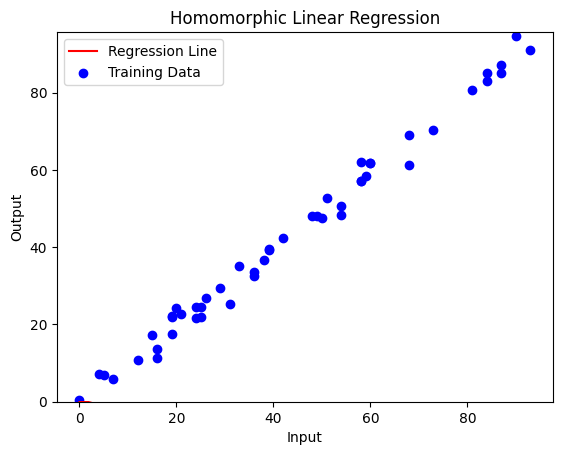

In [42]:
fig, ax = plt.subplots() 

line, = ax.plot(X, m[0] * X +
        c[0], color='red', label='Regression Line') 
ax.scatter(X, Y, marker='o', 
        color='blue', label='Training Data') 

# Set y-axis limits to exclude negative values 
ax.set_ylim(0, max(Y) + 1)

plt.xlabel('Input') 
plt.ylabel('Output') 
plt.title('Homomorphic Linear Regression') 
plt.legend() 
plt.show() 

break for optimization code 

In [9]:
!pip install dask
!pip install pandas
import dask

In [20]:

class HomomorphicLinearRegressionwithOptimize:

   
    def __init__(self, crypto_context, key_pair):
        self.crypto_context = crypto_context
        self.key_pair = key_pair
        self.parameters = {}

    @staticmethod
    @dask.delayed
    def _encrypt_single_data(crypto_context, key_pair, data):
        plaintext = crypto_context.MakeCKKSPackedPlaintext(data, 1, depth-1, None, 1)
        return crypto_context.Encrypt(key_pair.publicKey, plaintext)

    def encrypt_data(self, X, y):
        E_X = [self._encrypt_single_data(self.crypto_context, self.key_pair, [x]) for x in X]
        E_Y = [self._encrypt_single_data(self.crypto_context, self.key_pair, [y]) for y in Y]
        return dask.compute(*E_X), dask.compute(*E_Y)
    
    @dask.delayed
    def _eval_single_input(self, crypto_context, parameters, input):
        m = parameters['m']
        c = parameters['c']
        ciphertext_after = crypto_context.EvalBootstrap(input,2,17)
        eval_mul = crypto_context.EvalMult(ciphertext_after, m)
        eval_sum = crypto_context.EvalAdd(eval_mul, c)
        return eval_sum

    def forward_propagation(self, train_input):
        y_hats = [self._eval_single_input(self.crypto_context, self.parameters, x) for x in train_input]
        return dask.compute(*y_hats)

    def cost_function(self, predictions, train_output):
        if len(predictions) != len(train_output):
            return
        eval_cost = 0
        for y_hat, output in zip(predictions, train_output):
            eval_sub = self.crypto_context.EvalSub(y_hat,output)
            ciphertext_after = self.crypto_context.EvalBootstrap(eval_sub)
            eval_square = self.crypto_context.EvalSquare(ciphertext_after)
            eval_cost = self.crypto_context.EvalAdd(eval_square,eval_cost)
        ciphertext_after = self.crypto_context.EvalBootstrap(eval_cost)
        eval_cost = self.crypto_context.EvalMult(eval_cost,1/len(predictions))
        # result = self.crypto_context.Decrypt(eval_cost,self.key_pair.secretKey)
        # result.SetLength(1)
        # print("eval_cost = " + str(result))
        return eval_cost

    def mean_homo(self, Z):

        eval_cost = 0
        for z in Z:
            eval_cost = self.crypto_context.EvalAdd(z,eval_cost)
        c = 1 / len(Z)
        # Adjust noiseScaleDeg and level as needed
        ciphertext_after = self.crypto_context.EvalBootstrap(eval_cost)
        eval_mean = self.crypto_context.EvalMult(ciphertext_after,c)
        return eval_mean

    def backward_propagation(self, train_input, train_output, predictions):
        derivates = {}
        two = 2  # Adjust noiseScaleDeg and level as needed
        # Calculate dm 
        dfs = []
        for pred, output in zip(predictions, train_output):
            df = self.crypto_context.EvalSub(pred,output)
            dfs.append(df)
        eval_muls = []
        for i, df in zip(train_input, dfs):
            ciphertext_after = self.crypto_context.EvalBootstrap(i)
            ciphertext_after2 = self.crypto_context.EvalBootstrap(df)
            eval_mul = self.crypto_context.EvalMult(ciphertext_after,ciphertext_after2)
            eval_muls.append(eval_mul)
        mean = self.mean_homo(eval_muls)
        ciphertext_after = self.crypto_context.EvalBootstrap(mean)
        dm = self.crypto_context.EvalMult(ciphertext_after,two)
        # Calcualte the dc
        mean = self.mean_homo(dfs)
        ciphertext_after = self.crypto_context.EvalBootstrap(mean)
        dc = self.crypto_context.EvalMult(ciphertext_after, two)

        # Assign values to dm and dc
        derivates["dm"] = self.crypto_context.EvalBootstrap(dm)
        derivates["dc"] = self.crypto_context.EvalBootstrap(dc)
        return derivates

    def update_parameters(self, derivates, learning_rate):
        self.parameters["m"] = self.crypto_context.EvalSub(
            self.parameters["m"],
            self.crypto_context.EvalMult(learning_rate, derivates["dm"]),
        )
        self.parameters["c"] = self.crypto_context.EvalSub(
            self.parameters["c"],
            self.crypto_context.EvalMult(learning_rate, derivates["dc"]),
        )

    ##########################

    def train(self, E_X, E_Y, num_iterations=100, learning_rate=0.01):
        # Assuming E_X is structured correctly as per previous discussions
        # num_samples = len(E_X)  # Number of samples
        num_features = 8  # Assuming this is the correct way to determine the number of features

        # Initialize coefficients (weights and intercept) as encrypted 0.0 values
        # initial_plaintext = self.crypto_context.MakeCKKSPackedPlaintext([0.0])  # Adjust noiseScaleDeg and level as needed
        # self.coefficients = [self.crypto_context.Encrypt(self.key_pair.publicKey, initial_plaintext) for _ in range(num_features + 1)]
        
        self.parameters["m"] = np.random.uniform(0, 1) * -1
        
        self.parameters["c"] = np.random.uniform(0, 1) * -1
        self.loss = []

        # Initialize figure and axis for animation
        # fig, ax = plt.subplots()
        # x_vals = np.linspace(min(E_X), max(E_X), 100)
        # line, = ax.plot(x_vals, self.parameters['m'] * x_vals +
        #                 self.parameters['c'], color='red', label='Regression Line')
        # ax.scatter(X, y, marker='o',
        #         color='green', label='Training Data')

        # # Set y-axis limits to exclude negative values
        # ax.set_ylim(0, max(y) + 1)

        def update(i):
            # Forward propagation
            start_fp = time.time()
            predictions = self.forward_propagation(E_X)
            end_fp = time.time()
            print(f"Forward propagation with acceleration took {(end_fp - start_fp)/60:.8f} minutes.")
            # print(f"predictions: {predictions}")
            # print(f'E_Y: {E_Y}')
            # # Cost function
            # # Cost function
            start_cf = time.time()
            cost = self.cost_function(predictions, E_Y)
            end_cf = time.time()
            print(f"Cost function with acceleration calculation took {(end_cf - start_cf)/60:.8f} minutes.")

            # # Back propagation
            start_bp = time.time()
            derivatives = self.backward_propagation(E_X, E_Y, predictions)
            end_bp = time.time()
            print(f"Back propagation with acceleration took {(end_bp - start_bp)/60:.8f} minutes.")

            # # Update parameters
            self.update_parameters(derivatives, learning_rate)
            # # Update the regression line
            # # line.set_ydata(self.parameters['m']
            # #             * x_vals + self.parameters['c'])

            # Append loss and print
            self.loss.append(cost)
            print("Iteration = {}, Loss = {}".format(i + 1, cost))

            # return line,

        for i in range(15):
            update(i)

        m = self.crypto_context.Decrypt(self.parameters['m'],self.key_pair.secretKey)
        c = self.crypto_context.Decrypt(self.parameters['c'],self.key_pair.secretKey)
        # # Create animation
        # ani = FuncAnimation(fig, update, frames=num_iterations, interval=200, blit=True)
        # # Save the animation as a video file (e.g., MP4)
        # ani.save('linear_regression_A.gif', writer='ffmpeg')

        # plt.xlabel('Input')
        # plt.ylabel('Output')
        # plt.title('Linear Regression')
        # plt.legend()
        # plt.show()

        return m,c

    def decrypt_coefficients(self):
        if self.coefficients is None:
            print("Model coefficients are not trained yet.")
            return None
        else:
            return [
                self.crypto_context.Decrypt(self.key_pair.secretKey, coeff)
                for coeff in self.coefficients
            ]


In [21]:
# Initialize the class with cryptographic context and key pair
homo_lr_opt = HomomorphicLinearRegressionwithOptimize(crypto_context, key_pair)

# Encrypt the data
start_encrypt = time.time()
E_X, E_Y = homo_lr.encrypt_data(X, y)
end_encrypt = time.time()
print(f"Data encryption took {(end_encrypt - start_encrypt) / 60 :.8f} minutes.")


# Train the model
start_train = time.time()
m,c =homo_lr.train(E_X, E_Y)
end_train = time.time()
print(f"Model training took {(end_train - start_train) / 60:.8f} minutes.")
# Decrypt the trained coefficients
# coefficients = homo_lr.decrypt_coefficients()
# print("Trained coefficients:", coefficients)

/var/folders/9w/8ng_07_j477g3xhs5f7vds_c0000gn/T/ipykernel_73121/2329355311.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plaintext1 = crypto_context.MakeCKKSPackedPlaintext([x],1, depth -1,None,1)
/var/folders/9w/8ng_07_j477g3xhs5f7vds_c0000gn/T/ipykernel_73121/2329355311.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plaintext1 = crypto_context.MakeCKKSPackedPlaintext([y],1, depth -1,None,1)


Data encryption took 0.00187316 minutes.
Forward propagation took 0.20099355 minutes.
Cost function calculation took 0.20538307 minutes.
Back propagation took 0.41705347 minutes.
Iteration = 1, Loss = <openfhe.Ciphertext object at 0x171f48470>
Forward propagation took 0.20107605 minutes.
Cost function calculation took 0.20462201 minutes.
Back propagation took 0.41290947 minutes.
Iteration = 2, Loss = <openfhe.Ciphertext object at 0x29300abf0>
Forward propagation took 0.20095862 minutes.
Cost function calculation took 0.20673295 minutes.
Back propagation took 0.41755927 minutes.
Iteration = 3, Loss = <openfhe.Ciphertext object at 0x29300a170>
Forward propagation took 0.20251323 minutes.
Cost function calculation took 0.20574863 minutes.
Back propagation took 0.41710289 minutes.
Iteration = 4, Loss = <openfhe.Ciphertext object at 0x29300a030>
Model training took 3.29295525 minutes.
